In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import pyqg
from pyqg import diagnostic_tools as tools

colors = [(0.33725, 0.70588, 0.91373),
          (0.90196, 0.62353, 0.00000),
          (0.00000, 0.61961, 0.45098),
          (0.94118, 0.89412, 0.25882),
          (0.00000, 0.44706, 0.69804),
          (0.83529, 0.36863, 0.00000),
          (0.80000, 0.47451, 0.65490)]

In [5]:
def save_with_snapshots(m, tsnapint):
    
    model_output = m_bt.to_dataset()
    
    for _ in m.run_with_snapshots(tsnapstart = 0., tsnapint = tsnapint):
        
        model_output = xr.concat([model_output, m_bt.to_dataset()], dim = 'time')
        
    return model_output

# Tests with my edits for *linear* topographic slopes

## Test two layer QG model with my edits to the kernel and qg_model (test without linear or rough topography)

In [8]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = 50e3       # deformation radius    [m]
kd = 1. / Ld    # deformation wavenumber [m^-1]
nx = 256.       # number of grid cells per direction
ny = nx

# Background flow and topography
U1 = 0.01        # layer 1 background zonal velocity [m/s]
U2 = 0.          # layer 2 background zonal velocity [m/s]

H1 = 2500.       # depth of layer 1
delta = 1.       # layer depth ratio, \delta = H_1 / H_2, with total depth H = H_1 + H_2
hy = 0. #1e-5    # Gradient of topographic slope in y
hx = 0. #1e-5    # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

# htop = 100 * zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000

# year = 24 * 60 * 60 * 365.    
# tmax = 15 * year
# Ti = Ld / (abs(U1))   # estimate of most unstable e-folding time scale [s] (see 3-layer example in documentation)
# dt = Ti / 500.        # time-step [s]

m = pyqg.QGModel(nx = nx, L = L, rd = Ld, U1 = U1, U2 = U2,
                 H1 = H1, delta = delta, hx = hx, hy = hy, 
                 f0 = f0, beta = beta, rek = rek,
                 tmax = tmax, dt = dt, twrite = 10.)
m.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 6.57e-06, CFL: 0.000
INFO: Step: 20, Time: 3.60e+03, KE: 6.57e-06, CFL: 0.000
INFO: Step: 30, Time: 5.40e+03, KE: 6.57e-06, CFL: 0.000
INFO: Step: 40, Time: 7.20e+03, KE: 6.57e-06, CFL: 0.000
INFO: Step: 50, Time: 9.00e+03, KE: 6.57e-06, CFL: 0.000
INFO: Step: 60, Time: 1.08e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 70, Time: 1.26e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 80, Time: 1.44e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 90, Time: 1.62e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 100, Time: 1.80e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 110, Time: 1.98e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 120, Time: 2.16e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 130, Time: 2.34e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 140, Time: 2.52e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 150, Time: 2.70e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 160, Time: 2.88e+04, KE: 6.57e-06, CFL: 0.000
INFO: Step: 170, Time: 3.06e+04, KE: 6.57e-06, CFL: 0.0

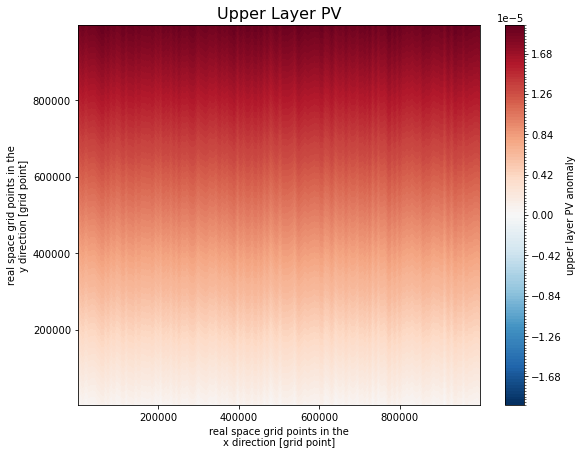

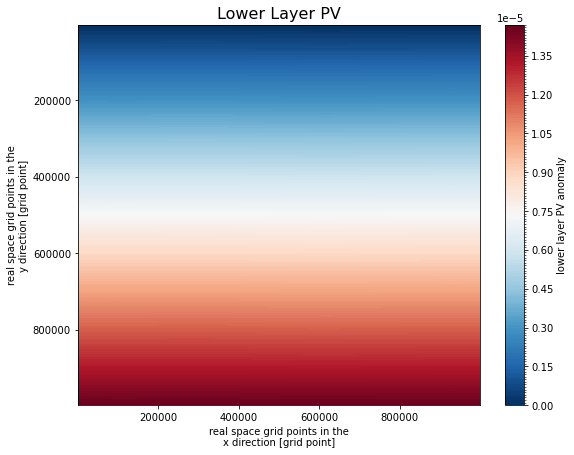

In [7]:
# Convert to xarray for nice metadata etc.

m_ds = m.to_dataset().isel(time=-1)

m_ds['q_upper'] = m_ds.q.isel(lev=0) + m_ds.Qy.isel(lev=0) * m_ds.y
m_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}

plt.figure(figsize=(9,7))
fontsize=16
m_ds.q_upper.plot.contourf(levels = 150, cmap = 'RdBu_r')
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)]
plt.title('Upper Layer PV', fontsize = fontsize)
# plt.savefig('upper_layer_pv_test.pdf', bbox_inches='tight', dpi=100)

m_ds['q_lower'] = m_ds.q.isel(lev=1) + m_ds.Qy.isel(lev=1) * m_ds.y
m_ds['q_lower'].attrs = {'long_name': 'lower layer PV anomaly'}

plt.figure(figsize=(9,7))
fontsize=16
m_ds.q_lower.plot.contourf(levels = 150, cmap = 'RdBu_r')
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)
plt.title('Lower Layer PV', fontsize = fontsize)
plt.gca().invert_yaxis()

Good.

## Test two layer QG model with my edits to the kernel and qg_model (test with linear topography but no roughness)

Same parameters as experiment run above, except now with linear slopes in x and y

In [20]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = 50e3       # deformation radius    [m]
kd = 1. / Ld    # deformation wavenumber [m^-1]
nx = 256.       # number of grid cells per direction
ny = nx

# Background flow and topography
U1 = 0.01        # layer 1 background zonal velocity [m/s]
U2 = 0.          # layer 2 background zonal velocity [m/s]

H1 = 2500.       # depth of layer 1
delta = 1.       # layer depth ratio, \delta = H_1 / H_2, with total depth H = H_1 + H_2
hy = 1e-5        # Gradient of topographic slope in y
hx = 1e-5        # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

# htop = 100 * zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000

# year = 24 * 60 * 60 * 365.    
# tmax = 15 * year
# Ti = Ld / (abs(U1))   # estimate of most unstable e-folding time scale [s] (see 3-layer example in documentation)
# dt = Ti / 500.        # time-step [s]

m = pyqg.QGModel(nx = nx, L = L, rd = Ld, U1 = U1, U2 = U2,
                 H1 = H1, delta = delta, hx = hx, hy = hy, 
                 f0 = f0, beta = beta, rek = rek,
                 tmax = tmax, dt = dt, twrite = 10.)
m.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 1.41e-06, CFL: 0.000
INFO: Step: 20, Time: 3.60e+03, KE: 1.41e-06, CFL: 0.000
INFO: Step: 30, Time: 5.40e+03, KE: 1.41e-06, CFL: 0.000
INFO: Step: 40, Time: 7.20e+03, KE: 1.41e-06, CFL: 0.000
INFO: Step: 50, Time: 9.00e+03, KE: 1.41e-06, CFL: 0.000
INFO: Step: 60, Time: 1.08e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 70, Time: 1.26e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 80, Time: 1.44e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 90, Time: 1.62e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 100, Time: 1.80e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 110, Time: 1.98e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 120, Time: 2.16e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 130, Time: 2.34e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 140, Time: 2.52e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 150, Time: 2.70e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 160, Time: 2.88e+04, KE: 1.41e-06, CFL: 0.000
INFO: Step: 170, Time: 3.06e+04, KE: 1.41e-06, CFL: 0.0

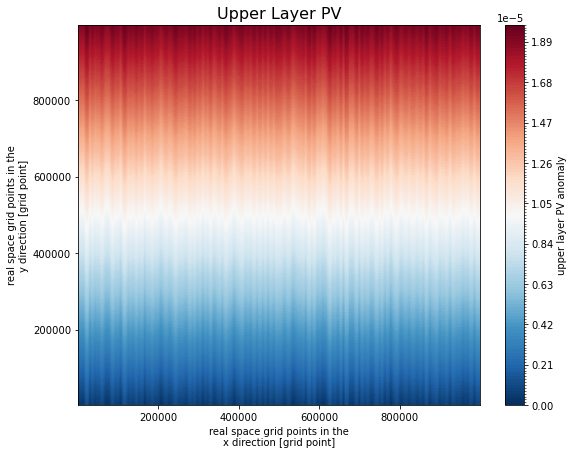

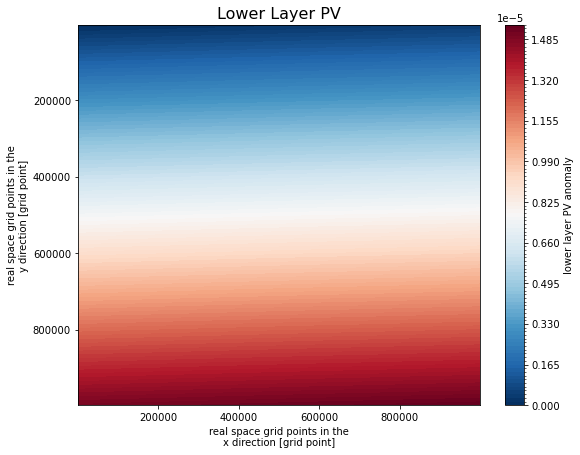

In [21]:
# Convert to xarray for nice metadata etc.

m_ds = m.to_dataset().isel(time=-1)

m_ds['q_upper'] = m_ds.q.isel(lev=0) + m_ds.Qy.isel(lev=0) * m_ds.y + m.Qx[0] * m_ds.x
m_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}

plt.figure(figsize=(9,7))
fontsize=16
m_ds.q_upper.plot.contourf(levels = 150, cmap = 'RdBu_r')
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)]
plt.title('Upper Layer PV', fontsize = fontsize)
# plt.savefig('upper_layer_pv_test.pdf', bbox_inches='tight', dpi=100)

m_ds['q_lower'] = m_ds.q.isel(lev=1) + m_ds.Qy.isel(lev=1) * m_ds.y + m.Qx[1] * m_ds.x
m_ds['q_lower'].attrs = {'long_name': 'lower layer PV anomaly'}

plt.figure(figsize=(9,7))
fontsize=16
m_ds.q_lower.plot.contourf(levels = 150, cmap = 'RdBu_r')
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)
plt.title('Lower Layer PV', fontsize = fontsize)
plt.gca().invert_yaxis()

Success again! Model ran fine. To be excected: an $h_y = 1e-5$ slope is equivalent to adding a $1e-12$ term to $\beta = 1e-11$, which we expect therefore to have a small effect.\\

Now let's try with some roughness in the topography!

## Test two layer QG model with my edits to the kernel and qg_model (test with linear and rough topography)

Same parameters as experiment run above, except now with linear slopes in x and y as well as roughness

In [36]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = 50e3       # deformation radius    [m]
kd = 1. / Ld    # deformation wavenumber [m^-1]
nx = 256.       # number of grid cells per direction
ny = nx

# Background flow and topography
U1 = 0.01        # layer 1 background zonal velocity [m/s]
U2 = 0.          # layer 2 background zonal velocity [m/s]

H1 = 2500.       # depth of layer 1
delta = 1.       # layer depth ratio, \delta = H_1 / H_2, with total depth H = H_1 + H_2
hy = 1e-5        # Gradient of topographic slope in y
hx = 1e-5        # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

htop = 100000 * zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000

# year = 24 * 60 * 60 * 365.    
# tmax = 15 * year
# Ti = Ld / (abs(U1))   # estimate of most unstable e-folding time scale [s] (see 3-layer example in documentation)
# dt = Ti / 500.        # time-step [s]

m = pyqg.QGModel(nx = nx, L = L, rd = Ld, U1 = U1, U2 = U2,
                 H1 = H1, delta = delta, hx = hx, hy = hy, htop = htop,
                 f0 = f0, beta = beta, rek = rek,
                 tmax = tmax, dt = dt, twrite = 10.)
m.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 3.12e-06, CFL: 0.001
INFO: Step: 20, Time: 3.60e+03, KE: 3.14e-06, CFL: 0.001
INFO: Step: 30, Time: 5.40e+03, KE: 3.30e-06, CFL: 0.000
INFO: Step: 40, Time: 7.20e+03, KE: 2.99e-06, CFL: 0.000
INFO: Step: 50, Time: 9.00e+03, KE: 3.21e-06, CFL: 0.000
INFO: Step: 60, Time: 1.08e+04, KE: 2.94e-06, CFL: 0.001
INFO: Step: 70, Time: 1.26e+04, KE: 2.91e-06, CFL: 0.001
INFO: Step: 80, Time: 1.44e+04, KE: 2.94e-06, CFL: 0.001
INFO: Step: 90, Time: 1.62e+04, KE: 2.98e-06, CFL: 0.000
INFO: Step: 100, Time: 1.80e+04, KE: 3.06e-06, CFL: 0.000
INFO: Step: 110, Time: 1.98e+04, KE: 2.82e-06, CFL: 0.000
INFO: Step: 120, Time: 2.16e+04, KE: 3.06e-06, CFL: 0.000
INFO: Step: 130, Time: 2.34e+04, KE: 2.93e-06, CFL: 0.000
INFO: Step: 140, Time: 2.52e+04, KE: 2.87e-06, CFL: 0.000
INFO: Step: 150, Time: 2.70e+04, KE: 3.12e-06, CFL: 0.000
INFO: Step: 160, Time: 2.88e+04, KE: 2.65e-06, CFL: 0.001
INFO: Step: 170, Time: 3.06e+04, KE: 2.83e-06, CFL: 0.0

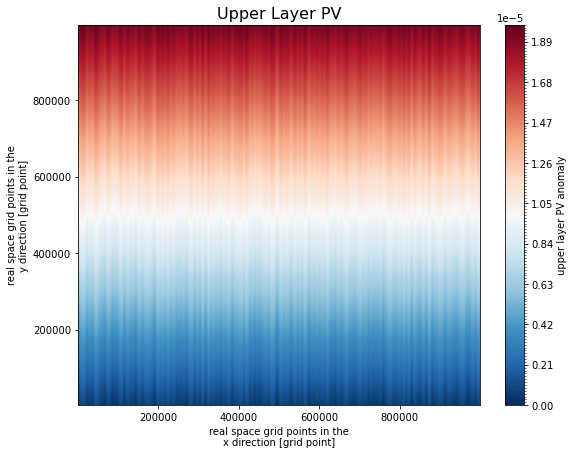

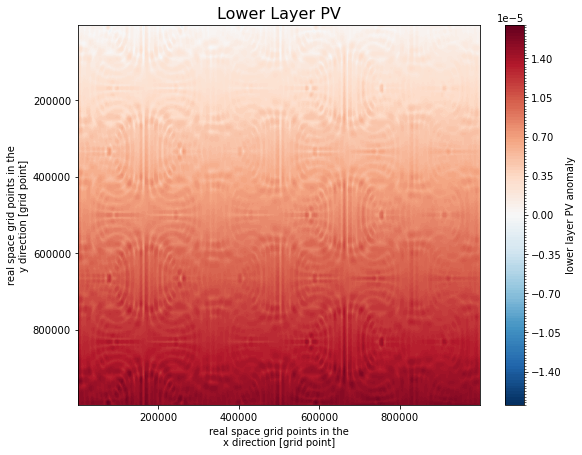

In [37]:
# Convert to xarray for nice metadata etc.

m_ds = m.to_dataset().isel(time=-1)

m_ds['q_upper'] = m_ds.q.isel(lev=0) + m_ds.Qy.isel(lev=0) * m_ds.y + m.Qx[0] * m_ds.x
m_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}

plt.figure(figsize=(9,7))
fontsize=16
m_ds.q_upper.plot.contourf(levels = 150, cmap = 'RdBu_r')
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)]
plt.title('Upper Layer PV', fontsize = fontsize)
# plt.savefig('upper_layer_pv_test.pdf', bbox_inches='tight', dpi=100)

m_ds['q_lower'] = m_ds.q.isel(lev=1) + m_ds.Qy.isel(lev=1) * m_ds.y + m.Qx[1] * m_ds.x
m_ds['q_lower'].attrs = {'long_name': 'lower layer PV anomaly'}

plt.figure(figsize=(9,7))
fontsize=16
m_ds.q_lower.plot.contourf(levels = 150, cmap = 'RdBu_r')
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)
plt.title('Lower Layer PV', fontsize = fontsize)
plt.gca().invert_yaxis()